In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import shapiro
import statsmodels.formula.api as smf
sns.set_style('whitegrid')

## Case study: The blood brain barrier - A controlled experiment
A layer of cells called the "blood-brain barrier" protects the human brain from bacteria and toxins. It also prevents passing through chemicals (antibody) used to treat brain tumors. So scientists test a disruption mechanism on the blood-brain barrier by infusing a solution of concentrated sugars into rats. 


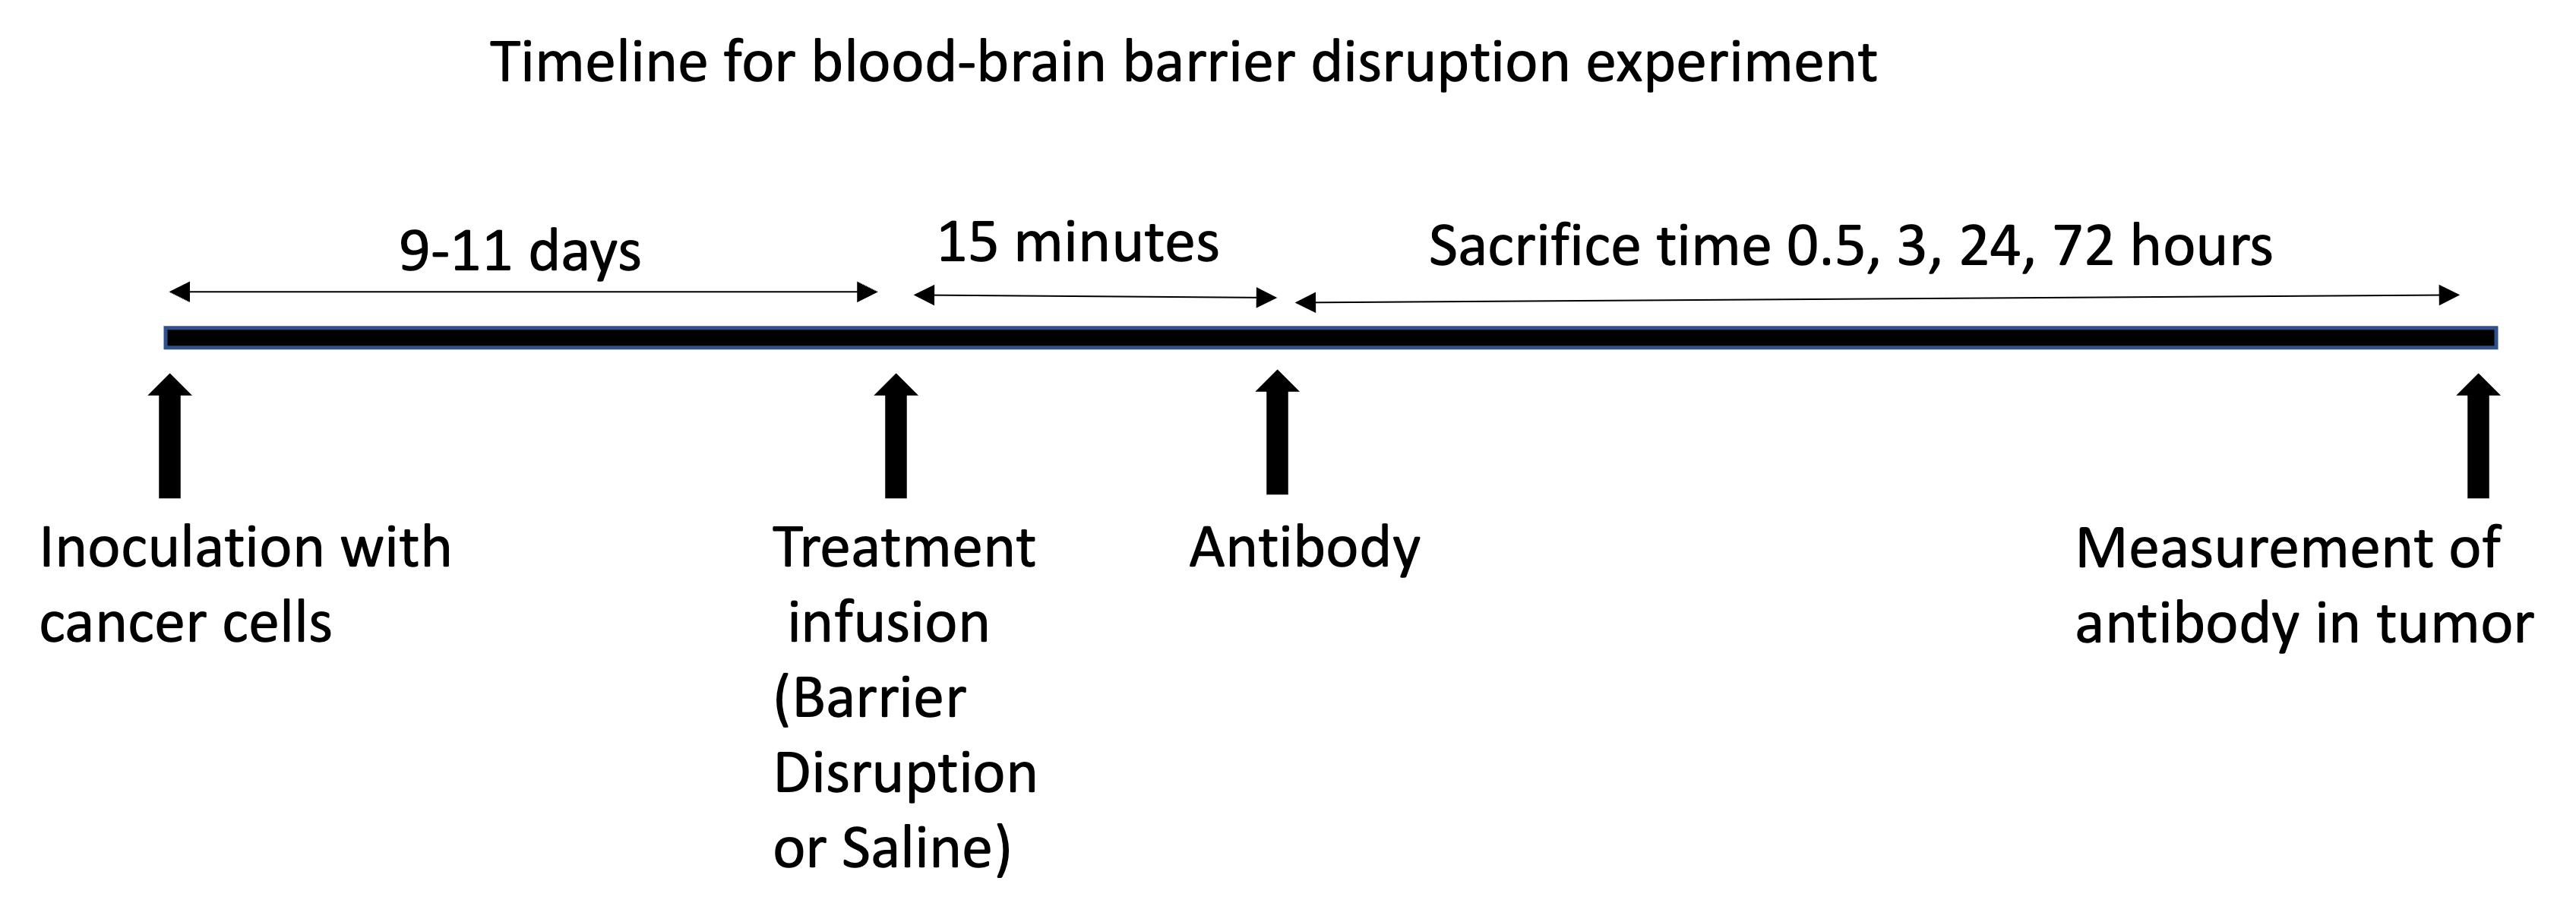



In [299]:
path = 'sleuth3csv/case1102.csv'
df = pd.read_csv(path)
display(df.head())
print(df.Treatment.unique())

,Brain,Liver,Time,Treatment,Days,Sex,Weight,Loss,Tumor
0,41081,1456164,0.5,BD,10,Female,239,5.9,221
1,44286,1602171,0.5,BD,10,Female,225,4.0,246
2,102926,1601936,0.5,BD,10,Female,224,-4.9,61
3,25927,1776411,0.5,BD,10,Female,184,9.8,168
4,42643,1351184,0.5,BD,10,Female,250,6.0,164


['BD' 'NS']


## Experiment questions:

1) Was the antibody concentration in the tumor increased by the use of the blood– brain barrier disruption infusion? 

2) If so, by how much? 

3) Do the answers to these two questions depend on the length of time after the infusion (from 1/2 to 72 hours)?

4) What is the effect of treatment on antibody concentration after weight loss, total tumor weight, and other  are accounted for? Covariates - measuring characteristics of the subjects that were not controllable by the researcher (sex, inital weight, weight loss and post inoculation tumor weight).

In [300]:
#The ratio of the antibody concentration in the brain tumor to that in the liver (outside).
df["Ratio"] = df["Brain"]/df["Liver"]
df.head(5)

,Brain,Liver,Time,Treatment,Days,Sex,Weight,Loss,Tumor,Ratio
0,41081,1456164,0.5,BD,10,Female,239,5.9,221,0.028212
1,44286,1602171,0.5,BD,10,Female,225,4.0,246,0.027641
2,102926,1601936,0.5,BD,10,Female,224,-4.9,61,0.064251
3,25927,1776411,0.5,BD,10,Female,184,9.8,168,0.014595
4,42643,1351184,0.5,BD,10,Female,250,6.0,164,0.031560


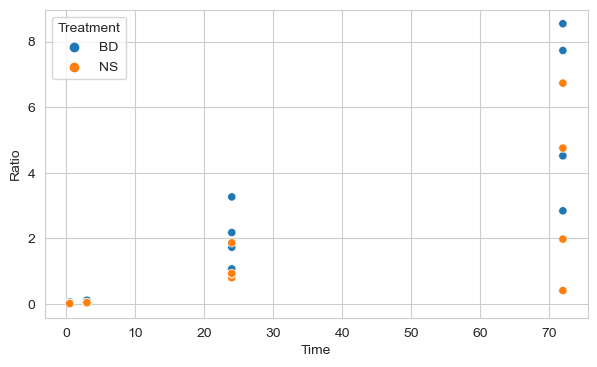

In [6]:
plt.figure(figsize = (7,4))
sns.scatterplot(x="Time", y="Ratio", hue = "Treatment", data = df)
plt.show()

Since variance is increasing with Time, let's check to see what the log-log scatter plot looks like.

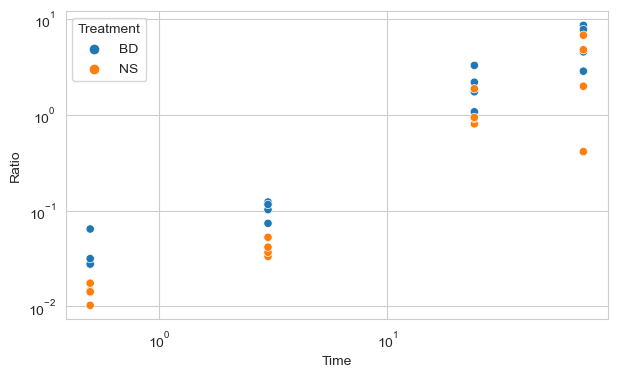

In [7]:
plt.figure(figsize = (7,4))
sns.scatterplot(x="Time", y="Ratio", hue = "Treatment", data = df).set( xscale="log", yscale='log')
plt.show()

This scatter plot represents a more clear linear association between these two variables. 

Also this scatter plot suggests that the difference between the two treatments may be greater for the shorter sacrifice times than for the longer ones (the effect of time on ratio depends on treatment type). So it may be good to consider an interaction term between sacrifice time and treatment.


Next in the next few slides we make scatter plots between some other selected variables. 

In [301]:
df["logRatio"] = np.log(df["Ratio"])
df["logTime"] = np.log(df["Time"])

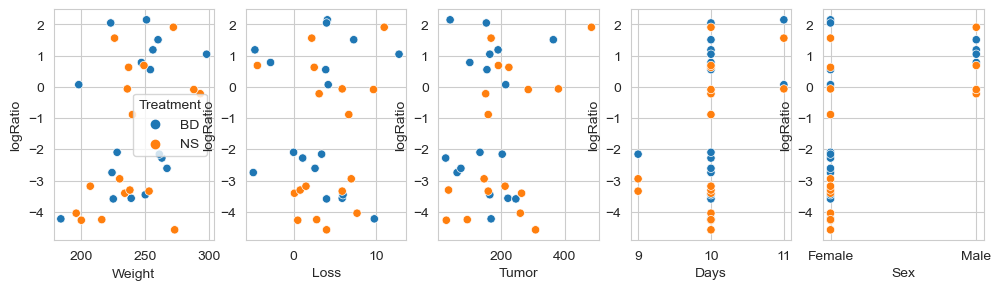

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 3))
sns.scatterplot(y='logRatio', x="Weight", hue='Treatment', data=df, ax = axes[0])
sns.scatterplot(y='logRatio', x="Loss", hue='Treatment', data=df, ax = axes[1], legend= False)
sns.scatterplot(y='logRatio', x="Tumor", hue='Treatment', data=df, ax = axes[2],legend= False)
sns.scatterplot(y='logRatio', x="Days", hue='Treatment', data=df, ax = axes[3], legend= False)
sns.scatterplot(y='logRatio', x="Sex", hue='Treatment', data=df, ax = axes[4],legend= False)
plt.show()

## Selecting a tentative model(s)

1) Model should contain parameters that lead to answering questions of the experiment

2) Include any potential confounding variables

3) Include features that capture important relationships (may base on the graphical analysis)

It is often not good to 

* add too many variables (risk of overfitting)

* or too few variables (outliers may appear - try several tentative models and conduct residual analysis).

If the sample size is substantially larger than the number of parameters then the risk of overfitting is less.

We select the following the tentative model:

$$\mu\{antibody|SAC, TREAT, DAYS, FEM, weight, loss, tumor\} = SAC+TREAT+(SAC*TREAT)+DAYS+FEM+weight+loss+tumor$$

where antibody is the log ratio, SAC is logTime (factor), TREAT is Treatment (factor) and FEM is Sex (factor).

In [69]:
df.head()

,Brain,Liver,Time,Treatment,Days,Sex,Weight,Loss,Tumor,Ratio,logRatio,logTime
0,41081,1456164,0.5,BD,10,Female,239,5.9,221,0.028212,-3.568015,-0.693147
1,44286,1602171,0.5,BD,10,Female,225,4.0,246,0.027641,-3.588446,-0.693147
2,102926,1601936,0.5,BD,10,Female,224,-4.9,61,0.064251,-2.744958,-0.693147
3,25927,1776411,0.5,BD,10,Female,184,9.8,168,0.014595,-4.227065,-0.693147
4,42643,1351184,0.5,BD,10,Female,250,6.0,164,0.031560,-3.455873,-0.693147


In [303]:
df = df.rename(columns = {"Treatment": "Treat"})

In [304]:
model = smf.ols("logRatio ~ C(logTime)+Treat+(C(logTime)*Treat)+C(Days)+C(Sex, Treatment(reference='Male'))+Weight+Loss+Tumor", data = df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               logRatio   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     39.54
Date:                Wed, 05 Apr 2023   Prob (F-statistic):           2.23e-11
Time:                        13:30:24   Log-Likelihood:                -19.444
No. Observations:                  34   AIC:                             66.89
Df Residuals:                      20   BIC:                             88.26
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

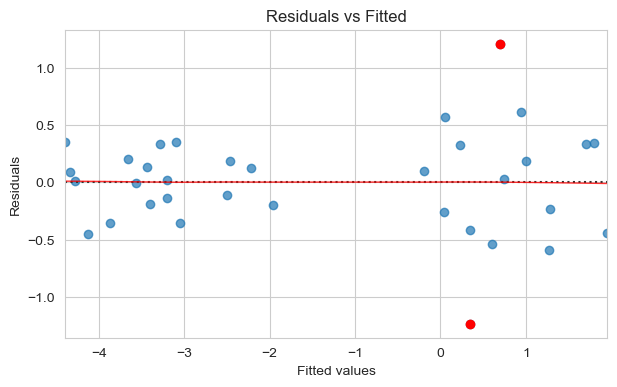

In [305]:
plt.figure(figsize=(7,4))
# fitted values (predicted values)
model_fitted_y = results.fittedvalues
#  Plot
plot = sns.residplot(x=model_fitted_y, y='logRatio', data=df, lowess=True, 
                     scatter_kws={'alpha': 0.7}, 
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
filter_ = (results.resid < -1) | (results.resid > 1)
plt.plot(model_fitted_y[filter_], results.resid[filter_], 'o', color='red', markersize=6)

# Titel and labels
plot.set_title('Residuals vs Fitted')
plot.set_xlabel('Fitted values')
plot.set_ylabel('Residuals');

In [306]:
filter_

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30     True
31    False
32    False
33     True
dtype: bool

## Residual vs Fitted values plot:

Is there a funnel-shaped pattern?

Or is the apparent funnel only due to a few outliers (potentially two)?

1) Examine the outliers for recording error or contamination.

2) Check whether a standard transformation resolves the problem (reciprocal?).

3) If neither of these steps works, examine the outliers more carefully to see whether they influence the conclusions.

### Are these two red points influential?

## Case study: Alcohol Metabolism in Men and Women—An Observational Study

When men and women of the same size and drinking history consume equal amounts of alcohol, the women on average carry a higher concentration of alcohol in their bloodstream.

This occurs because alcohol-degrading enzymes in the stomach (where alcohol is partially metabolized before it enters the bloodstream and is eventually metabolized by the liver) are more active in men than in women. 

The researchers studied the extent to which the activity of the enzyme explained the first-pass alcohol metabolism and the extent to which it explained the differences in first-pass metabolism between women and men.

All subjects received ethanol, at a dose of 0.3 grams per kilogram of body weight, the difference in blood alcohol concentration provides a measure of the “first-pass metabolism” in the stomach.

In addition, gastric alcohol dehydrogenase (AD) activity (activity of the key enzyme) was measured.

In [307]:
path = 'sleuth3csv/case1101.csv'
df_metabol = pd.read_csv(path)
df_metabol.head()

,Subject,Metabol,Gastric,Sex,Alcohol
0,1,0.6,1.0,Female,Alcoholic
1,2,0.6,1.6,Female,Alcoholic
2,3,1.5,1.5,Female,Alcoholic
3,4,0.4,2.2,Female,Non-alcoholic
4,5,0.1,1.1,Female,Non-alcoholic


In [309]:
df_metabol.Alcohol.value_counts()

Non-alcoholic    24
Alcoholic         8
Name: Alcohol, dtype: int64

In [310]:
df_metabol

,Subject,Metabol,Gastric,Sex,Alcohol
0,1,0.6,1.0,Female,Alcoholic
1,2,0.6,1.6,Female,Alcoholic
2,3,1.5,1.5,Female,Alcoholic
3,4,0.4,2.2,Female,Non-alcoholic
4,5,0.1,1.1,Female,Non-alcoholic
5,6,0.2,1.2,Female,Non-alcoholic
6,7,0.3,0.9,Female,Non-alcoholic
7,8,0.3,0.8,Female,Non-alcoholic
8,9,0.4,1.5,Female,Non-alcoholic
9,10,1.0,0.9,Female,Non-alcoholic


In [273]:
df_metabol.shape

(32, 5)

## Research questions:

1) Do levels of first-pass metabolism differ between men and women? 

2) Can the differences be explained by postulating that men have more dehydrogenase activity (AD) in their stomachs?

3) Are the answers to these questions complicated by an alcoholism effect?

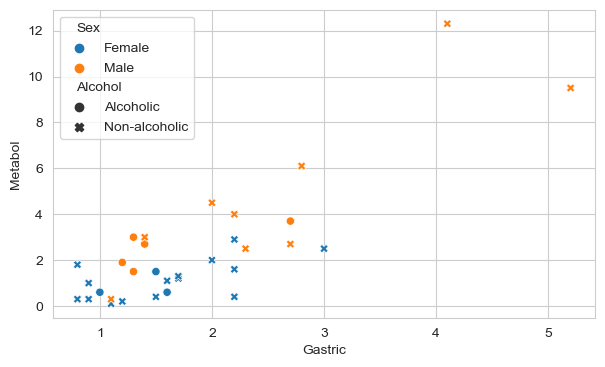

In [263]:
plt.figure(figsize = (7,4))
sns.scatterplot(x="Gastric", y="Metabol", hue = "Sex", style="Alcohol", data = df_metabol)
plt.show()

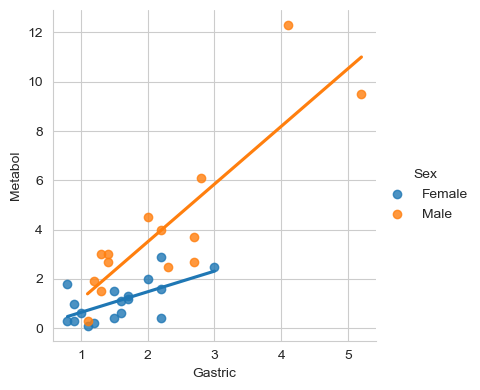

In [281]:
#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
sns.lmplot(data=df_metabol, x="Gastric", y="Metabol", hue="Sex", ci=None,  
           facet_kws=dict(sharex=False, sharey=False), height=4)
plt.show()

The difference in male and female line slopes suggest an interaction effect between sex and gastric.

Tentative model:


$$\mu\{Metabol|Gast, FEM, ALCO\}= Gas+FEM+ALCO+(Gas*FEM)+(FEM*ALCO)+(Gas*AlCO)+(Gas*FEM*ALCO)$$



In [264]:
model_metabol = smf.ols('''Metabol ~ Gastric+C(Sex, Treatment(reference='Male'))+C(Alcohol,Treatment(reference='Non-alcoholic'))
+Gastric*C(Sex, Treatment('Male'))+C(Sex, Treatment('Male'))*C(Alcohol,Treatment(reference='Non-alcoholic'))
+Gastric*C(Alcohol,Treatment(reference='Non-alcoholic'))+Gastric*C(Sex, Treatment('Male'))*C(Alcohol,Treatment(reference='Non-alcoholic'))'''
                 , data = df_metabol)
results_metabol = model_metabol.fit()
display(results_metabol.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Metabol   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     16.47
Date:                Tue, 04 Apr 2023   Prob (F-statistic):           9.35e-08
Time:                        21:10:20   Log-Likelihood:                -48.052
No. Observations:                  32   AIC:                             112.1
Df Residuals:                      24   BIC:                             123.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================================================================
                                                                                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                    -1.6597      1.000     -1.660      0.110      -3.723       0.404
C(Sex, Treatment(reference='Male'))[T.Female]                                                                 0.7329      0.666      1.100      0.282      -0.642       2.108
C(Alcohol, Treatment(reference='Non-alcoholic'))[T.Alcoholic]                                                 2.5521      1.946      1.311      0.202      -1.464       6.568
C(Sex, Treatment('Male'))[T.Female]                                                                           0.7329      0.666      1.100      0.282      -0.642       2.108
C(Sex, Treatment('Male'))[T.Female]:C(Alcohol, Treatment(reference='Non-alcoholic'))[T.Alcoholic]            -2.2517      4.394     -0.512      0.613     -11.320       6.816
Gastric                                                                                                       2.5142      0.343      7.322      0.000       1.805       3.223
Gastric:C(Sex, Treatment('Male'))[T.Female]                                                                  -1.6734      0.620     -2.698      0.013      -2.953      -0.393
Gastric:C(Alcohol, Treatment(reference='Non-alcoholic'))[T.Alcoholic]                                        -1.4587      1.053     -1.386      0.179      -3.632       0.714
Gastric:C(Sex, Treatment('Male'))[T.Female]:C(Alcohol, Treatment(reference='Non-alcoholic'))[T.Alcoholic]     1.1987      2.998      0.400      0.693      -4.989       7.386
==============================================================================
Omnibus:                        9.228   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               10.936
Skew:                           0.672   Prob(JB):                      0.00422
Kurtosis:                       5.529   Cond. No.                     6.11e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.74e-34. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Text(0, 0.5, 'Residuals')

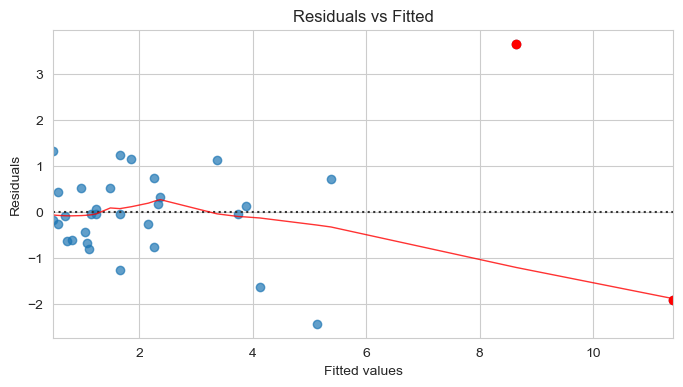

In [199]:
plt.figure(figsize=(8,4))
# fitted values (predicted values)
model_fitted_y = results_metabol.fittedvalues
#  Plot
plot = sns.residplot(x=model_fitted_y, y='Metabol', data=df_metabol, lowess=True, 
                     scatter_kws={'alpha': 0.7}, 
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
filter_ = (model_fitted_y > 10) | (results_metabol.resid > 3)
plt.plot(model_fitted_y[filter_], results_metabol.resid[filter_], 'o', color='red', markersize=6)

# Titel and labels
plot.set_title('Residuals vs Fitted')
plot.set_xlabel('Fitted values')
plot.set_ylabel('Residuals')

The plot draws attention to two observations: one that has a considerably larger residual than the rest and one that has a fitted value quite a bit larger than the rest.

There appears to be a downward trend in the residual plot, excluding those two points.

This reflects a model that is influenced by one or two observations and consequently does not fit the bulk of the observations well.

## A strategy for dealing with influential observations.

1) Remove suspected influential observations and see whether the answers to the questions of interest change.

2) Does the evidence from a test change from slight evidence to convincing evidence?

3) Does the decision to include a term in the model change?

4) Does an important estimate change by a practically relevant amount?

If not, the observation is not influential and the analysis can proceed as usual. 

If so, further action must be taken.

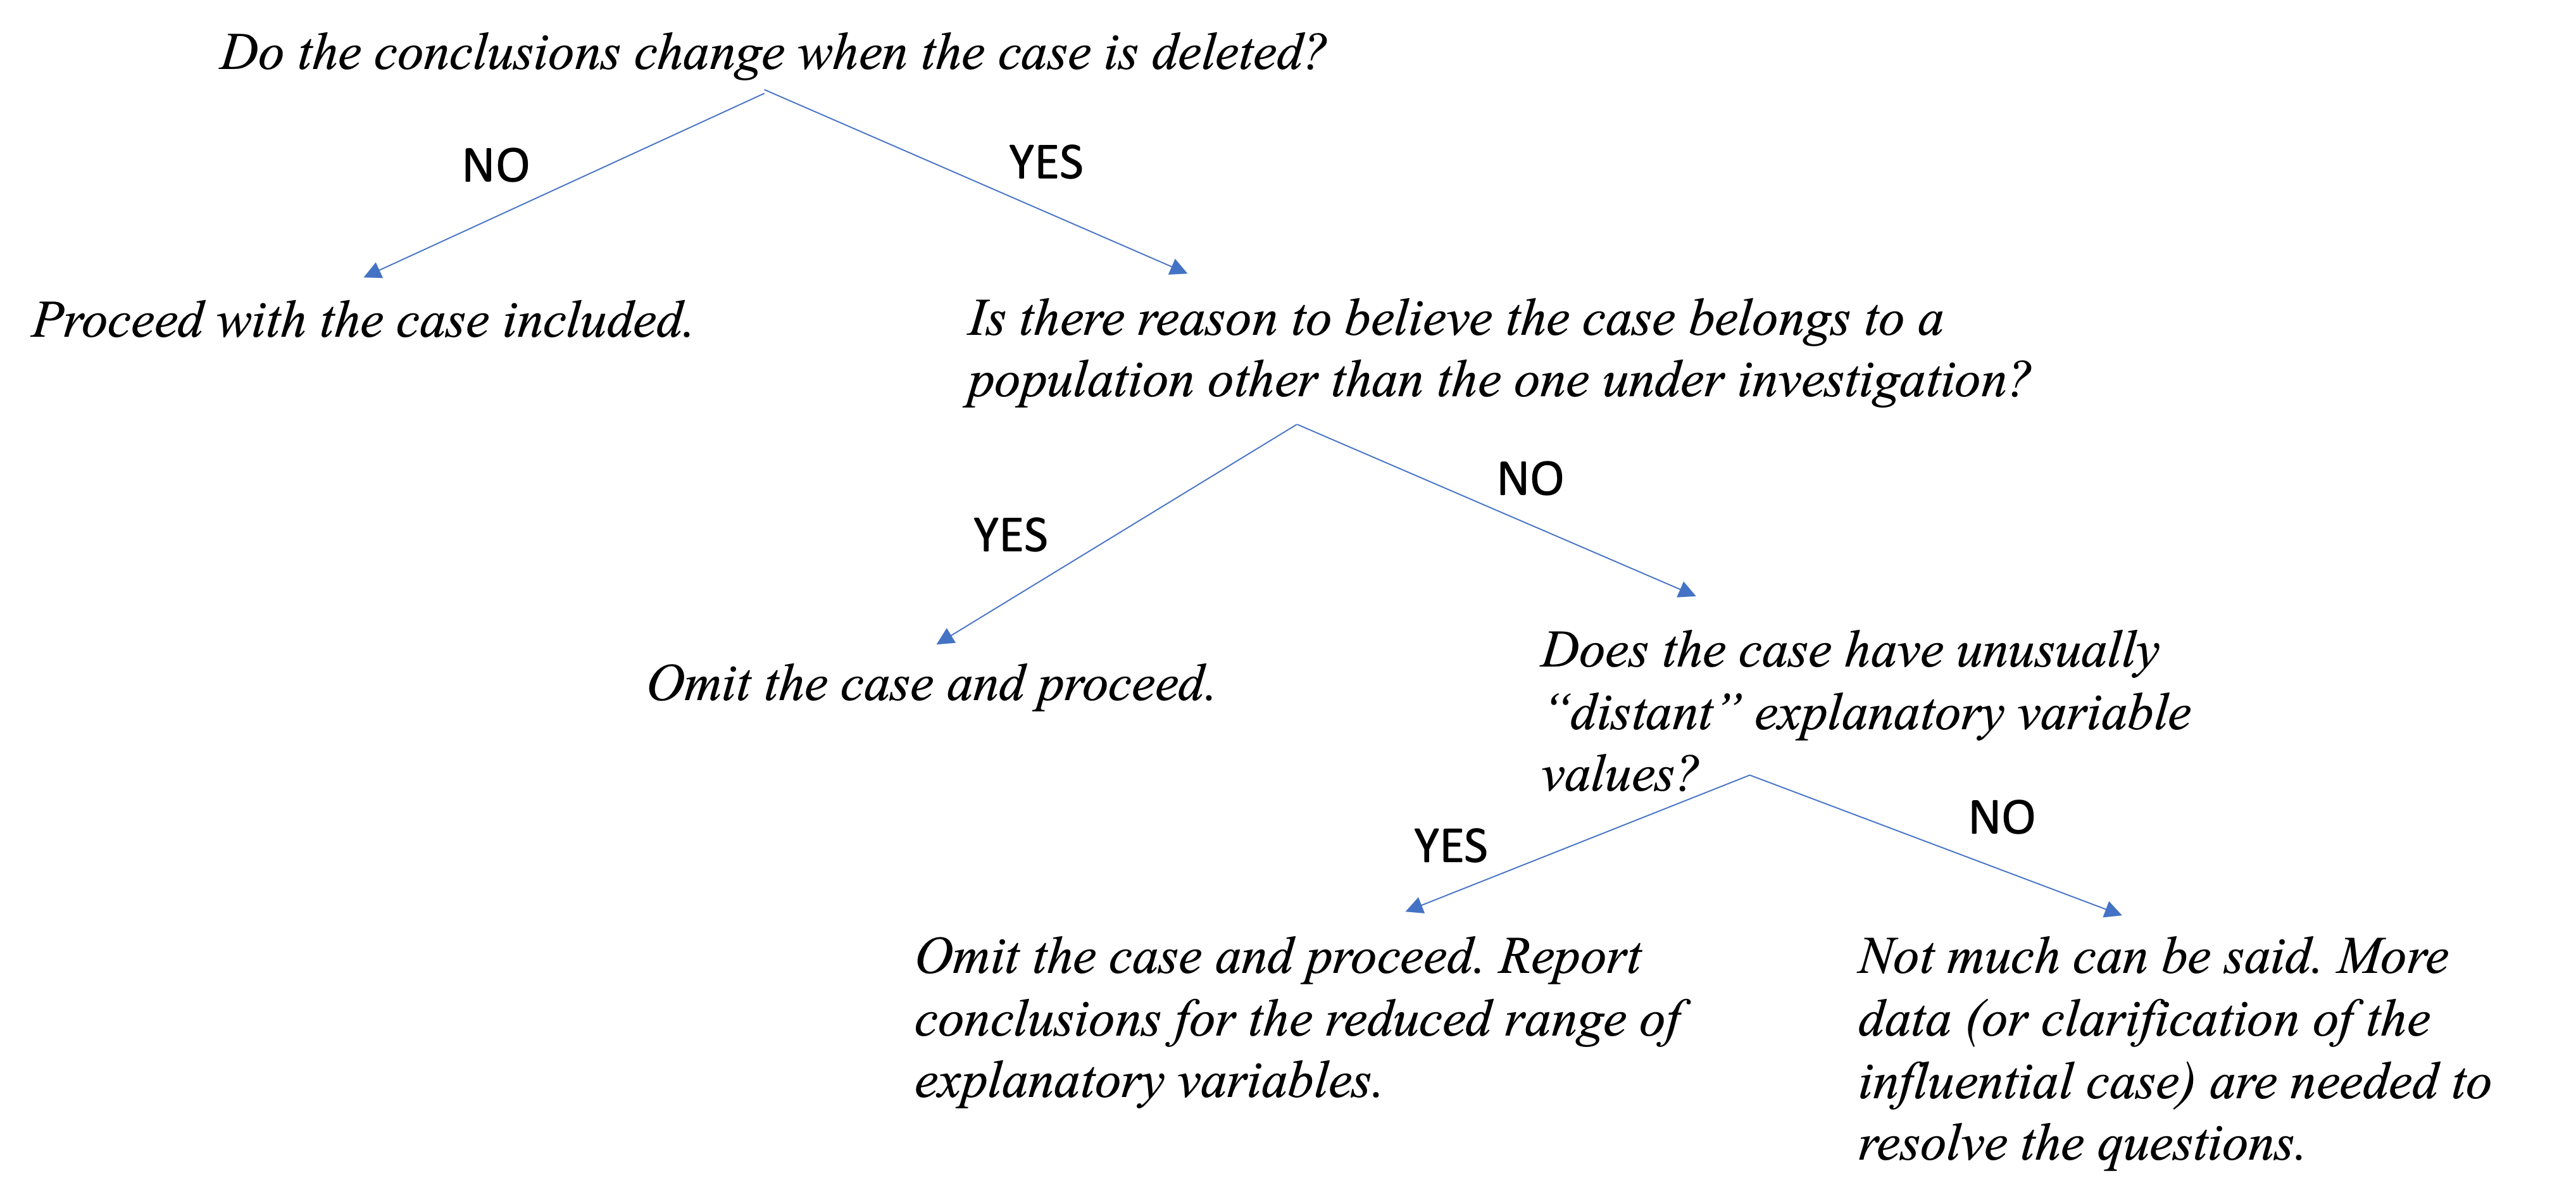

### Let's remove the case and conduct the same analysis.

In [200]:
df3 = df_metabol[~filter_]

In [114]:
model3 = smf.ols('''Metabol ~ Gastric+C(Sex, Treatment(reference='Male'))+C(Alcohol,Treatment(reference='Non-alcoholic'))
+Gastric*C(Sex, Treatment('Male'))+C(Sex, Treatment('Male'))*C(Alcohol,Treatment(reference='Non-alcoholic'))
+Gastric*C(Alcohol,Treatment(reference='Non-alcoholic'))+Gastric*C(Sex, Treatment('Male'))*C(Alcohol,Treatment(reference='Non-alcoholic'))'''
                 , data = df3)
results3 = model3.fit()
display(results3.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Metabol   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     6.831
Date:                Mon, 03 Apr 2023   Prob (F-statistic):           0.000226
Time:                        22:43:46   Log-Likelihood:                -36.094
No. Observations:                  30   AIC:                             88.19
Df Residuals:                      22   BIC:                             99.40
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================================================================
                                                                                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                    -0.6797      1.309     -0.519      0.609      -3.395       2.035
C(Sex, Treatment(reference='Male'))[T.Female]                                                                 0.2429      0.733      0.331      0.744      -1.278       1.764
C(Alcohol, Treatment(reference='Non-alcoholic'))[T.Alcoholic]                                                 1.5722      1.812      0.868      0.395      -2.185       5.330
C(Sex, Treatment('Male'))[T.Female]                                                                           0.2429      0.733      0.331      0.744      -1.278       1.764
C(Sex, Treatment('Male'))[T.Female]:C(Alcohol, Treatment(reference='Non-alcoholic'))[T.Alcoholic]            -1.2718      3.467     -0.367      0.717      -8.462       5.918
Gastric                                                                                                       1.9212      0.608      3.159      0.005       0.660       3.183
Gastric:C(Sex, Treatment('Male'))[T.Female]                                                                  -1.0805      0.721     -1.498      0.148      -2.576       0.415
Gastric:C(Alcohol, Treatment(reference='Non-alcoholic'))[T.Alcoholic]                                        -0.8658      0.963     -0.899      0.378      -2.863       1.132
Gastric:C(Sex, Treatment('Male'))[T.Female]:C(Alcohol, Treatment(reference='Non-alcoholic'))[T.Alcoholic]     0.6058      2.316      0.262      0.796      -4.197       5.408
==============================================================================
Omnibus:                        0.110   Durbin-Watson:                   1.339
Prob(Omnibus):                  0.947   Jarque-Bera (JB):                0.312
Skew:                          -0.087   Prob(JB):                        0.856
Kurtosis:                       2.532   Cond. No.                     8.35e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.66e-36. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

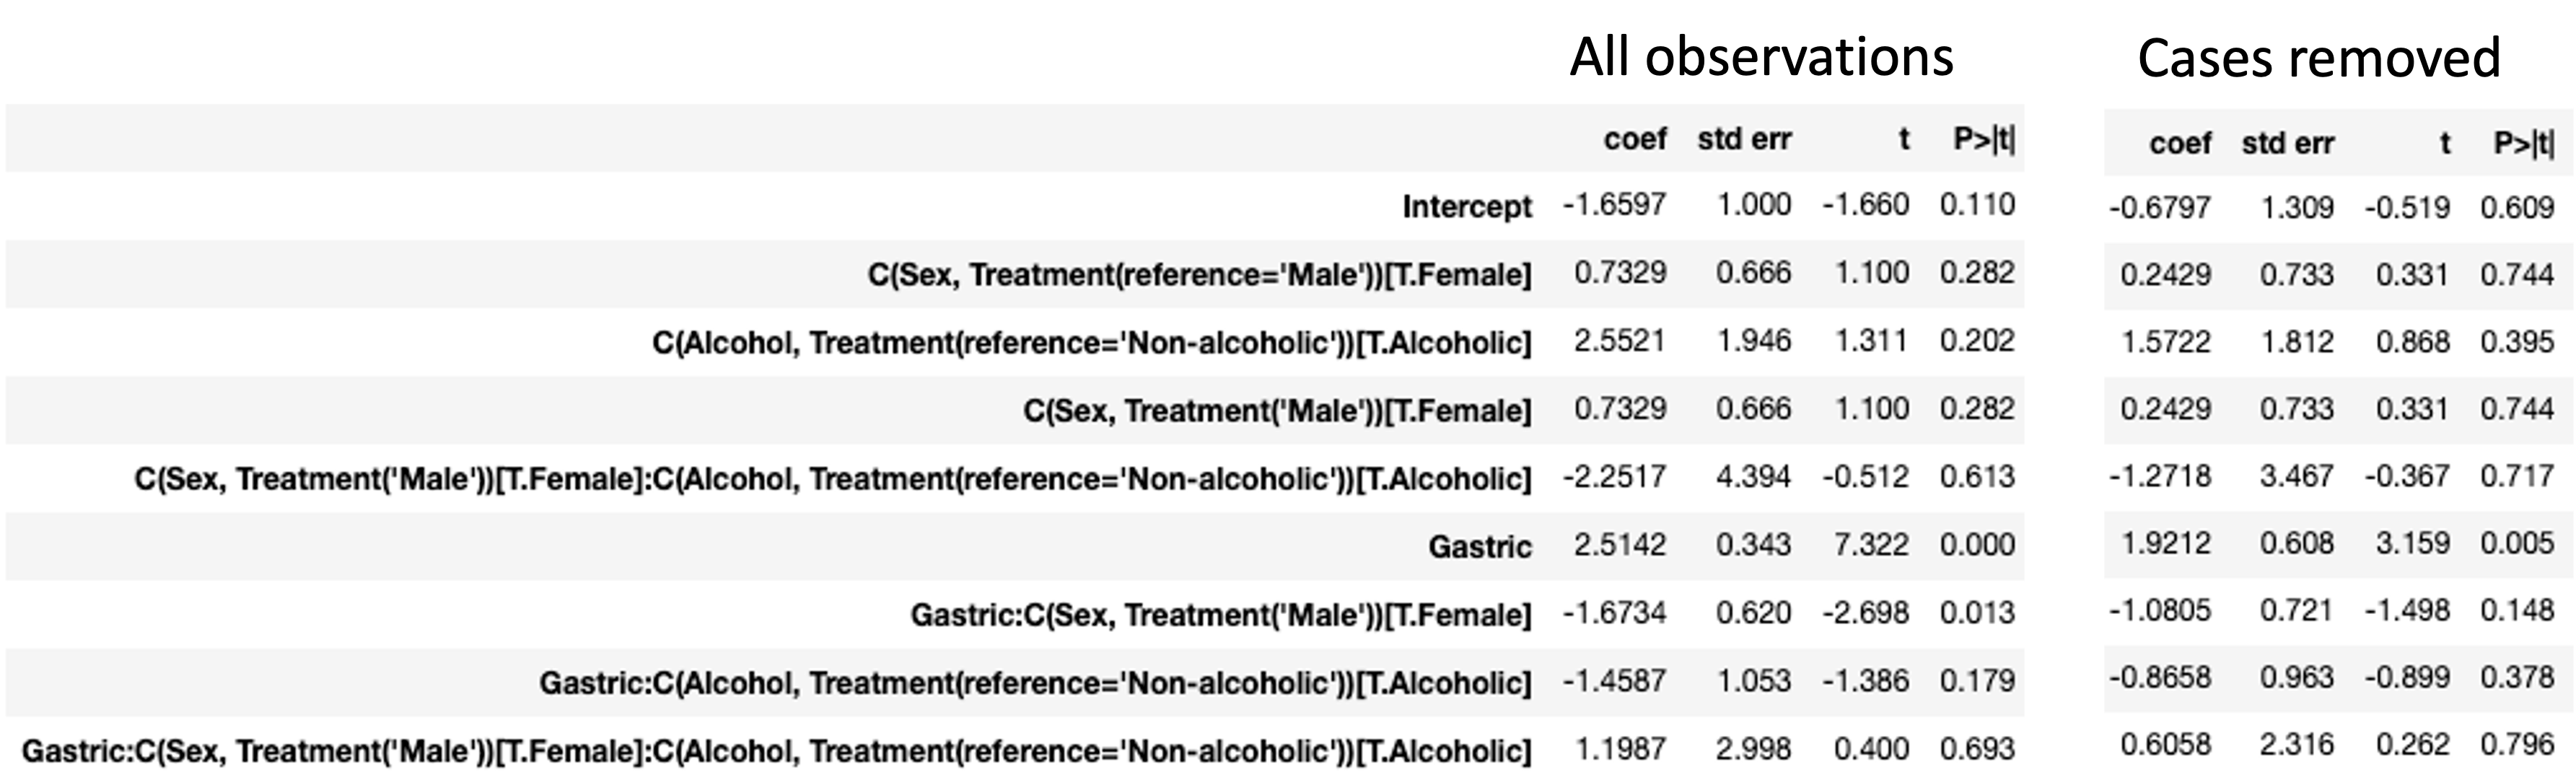

A striking consequence of the exclusion cases is that the drop in significance of the interaction of gastric activity and sex from a p-value of 0.013 to one of 0.148.

The reason for this change is evident from the scatter plot between Gastric and Metabol. 

The slope for males is substantially greater with cases included, than with them excluded.

/var/folders/df/t690wl_95dg61prvkr2c5pbc0000gp/T/ipykernel_27774/2427999213.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4.loc[df4.index,"cases"] = "All"


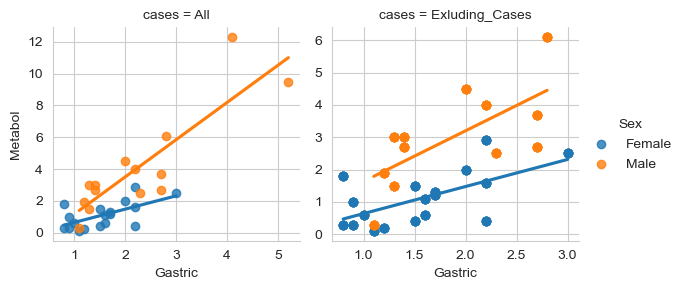

In [145]:
df4 = df2[["Gastric","Metabol","Sex"]]
df4.loc[df4.index,"cases"] = "All"

df5 = df2[~filter_]
df5 = df5[["Gastric","Metabol","Sex"]]
df5["cases"] = ["Exluding_Cases"]*df5.shape[0]

#df6 = df4.append(df5, ignore_index = True)
df6 = pd.concat([df6, df5], ignore_index=True)

#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
sns.lmplot(data=df6, x="Gastric", y="Metabol", hue="Sex", ci=None, col = "cases",  
           facet_kws=dict(sharex=False, sharey=False), height=3)
plt.show()

## Case-influence statistics

Case-influence statistics are numerical measures associated with the individual influence of each observation (each case).

### Leverages for Flagging Cases with Unusual Explanatory Variable Values

The leverage of a case is a measure of the distance between its explanatory variable values and the average of the explanatory variable values in the entire data set.

High leverage may exert strong influence on the results of model fitting.

The leverage of the ith case, when only a single explanatory variable $X$ is involved, is defined as

$$h_i = \frac{1}{(n-1)}\big[\frac{(x_i-\bar{X})}{S_X}\big]^2+\frac{1}{n}=\frac{(x_i-\bar{X})^2}{\sum_{j=1}^n(x_j-\bar{X})^2}+\frac{1}{n}$$

where $S_X$ is the sample standard deviation of $X$. 

One can think of leverage as the distance of $X_i$ from $\bar{X}$, in units of standard deviations.

Note that $\frac{1}{n}<h_i<1$ and Average$(h_i)=\frac{p}{n}$ where $p$ is the number of model coefficients (leverage depends on the model).

### Optional:
For multivariable regression: Leverage takes the matrix form:

$$H=X(X^TX)^{-1}X^T$$

where $X$ is the input matrix of the model. The diagonal elements of $H$ are the leverage values.

Leverages also can be expressed as $h_i=\frac{Cov(\hat{y}_i,y_i)}{Var(y_i)}$

Also model output in matrix notation can be written in terms of $H$ as $\hat{Y}=HY$.





In [149]:
#Example
x = [7,7,7,7,7,7,7,7,7,7,20]
y = [5.1,5.2,5.3,6.8,6.9,7,7.9,8,8.5,9,12.5]

df_temp = pd.DataFrame()
df_temp["X"] = x
df_temp["Y"] = y

df_temp.tail()


,X,Y
6,7,7.9
7,7,8.0
8,7,8.5
9,7,9.0
10,20,12.5


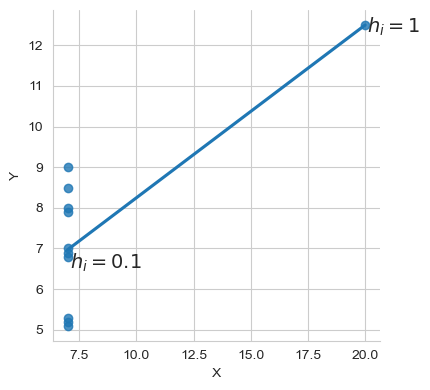

In [174]:
sns.lmplot(x="X", y="Y", data = df_temp, ci=None, height=4)
plt.annotate(r"$h_i=0.1$", (7.1, 6.5), size=14)
plt.annotate(r"$h_i=1$", (20.1, 12.3), size=14)
plt.show()

The point (20, 12.5) takes full leverage of 1 unit. Each of the other points equally shares the leverage at (7.5,6.97) so each has a leverage of 0.1.

### Residual variance $\hat{\sigma}^2$

$\hat{\sigma}^2 = \frac{1}{n-p}\sum_{i=1}^n res_i^2$

where $p$ is the number of coefficients in the model and $res_i$ is the residual of the point $i$.

$Var(res_i) = \hat{\sigma}^2(1-h_i) \implies SE(res_i)=\hat{\sigma}\sqrt{1-h_i}$

Note that $h_i=1\implies res_i=0$. This also can be seen from the diagram above, the point (20,12.5). That is, the model always passes exactly through this point.

Another formula, $h_i = [\frac{SE(fit_i)}{\hat{\sigma}}]^2$ 

***A large leverage does not necessarily indicate that the case is influential, it does imply that the case has a high potential for influence.***

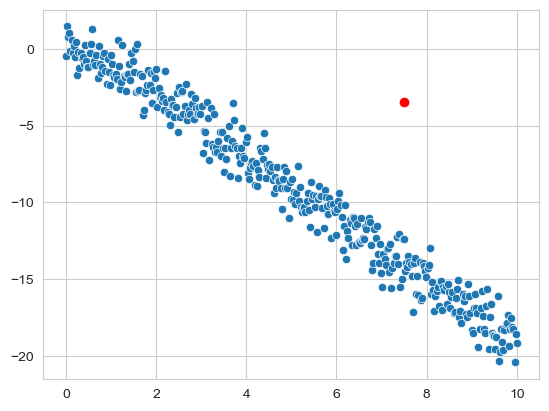

In [192]:
x = np.linspace(0,10,400)

y = 1-2*x+np.random.normal(0, 1, 400)

#x = np.append(x, [7.5])
#y = np.append(y, [(min(y)+max(y))/2+6])

sns.scatterplot(x = x,y = y)
plt.plot(7.5,(min(y)+max(y))/2+6, 'ro')
plt.show()

The plot above illustrates a problem in which one case is relatively far from the two-dimensional scatter of the other cases, although it is not particularly unusual in either of the single dimensions. 

This point has a high potential for influence. The multiple regression version of leverage would be large for such an observation.

Since the average of the $h_i$ is $\frac{p}{n}$, some statisticians use twice the average $\frac{2p}{n}$ as a lower cutoff for flagging cases that have a high potential for excessive influence. 


## Studentized Residuals for Flagging Outliers

A studentized residual ($studres_i$) is a residual divided by its estimated standard deviation.

$$studres_i = \frac{res_i}{SE(res_i)} = \frac{res_i}{\hat{\sigma}\sqrt{1-h_i}} $$

It is common to investigate observations whose studentized residuals are smaller than -2 or larger than 2.

Now we fit a model on Metabolism only considering Gastric and sex indicator variable and their interaction. We calculate the leverage and studentized residual value for observation 31.

In [267]:
model_metabol2 = smf.ols('''Metabol ~ Gastric+C(Sex, Treatment(reference='Male'))+Gastric*C(Sex, Treatment('Male'))'''
                 , data = df_metabol)
results_metabol2 = model_metabol2.fit()
display(results_metabol2.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Metabol   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     40.77
Date:                Tue, 04 Apr 2023   Prob (F-statistic):           2.39e-10
Time:                        21:17:09   Log-Likelihood:                -49.298
No. Observations:                  32   AIC:                             106.6
Df Residuals:                      28   BIC:                             112.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                        -1.1858      0.712     -1.666      0.107      -2.644       0.272
C(Sex, Treatment(reference='Male'))[T.Female]     0.4942      0.536      0.922      0.365      -0.604       1.593
C(Sex, Treatment('Male'))[T.Female]               0.4942      0.536      0.922      0.365      -0.604       1.593
Gastric                                           2.3439      0.280      8.367      0.000       1.770       2.918
Gastric:C(Sex, Treatment('Male'))[T.Female]      -1.5069      0.559     -2.695      0.012      -2.652      -0.362
==============================================================================
Omnibus:                       10.468   Durbin-Watson:                   1.667
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               12.581
Skew:                           0.793   Prob(JB):                      0.00185
Kurtosis:                       5.630   Cond. No.                     1.08e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.79e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Text(0, 0.5, 'Residuals')

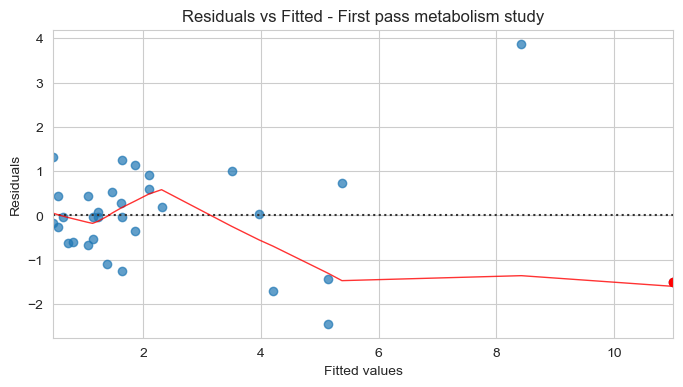

In [209]:
plt.figure(figsize=(8,4))
# fitted values (predicted values)
model_fitted_y = results_metabol2.fittedvalues
#  Plot
plot = sns.residplot(x=model_fitted_y, y='Metabol', data=df_metabol, lowess=True, 
                     scatter_kws={'alpha': 0.7}, 
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
filter_ = (model_fitted_y > 10)
plt.plot(model_fitted_y[filter_], results_metabol2.resid[filter_], 'o', color='red', markersize=6)

# Titel and labels
plot.set_title('Residuals vs Fitted - First pass metabolism study')
plot.set_xlabel('Fitted values')
plot.set_ylabel('Residuals')

In [245]:
#create instance of influence
influence = results_metabol2.get_influence()

#leverage (hat values)
leverage = influence.hat_matrix_diag

In [246]:
leverage

array([0.10414993, 0.05595716, 0.05595716, 0.12342704, 0.08808568,
       0.07523427, 0.12342704, 0.145917  , 0.05595716, 0.12342704,
       0.05595716, 0.05917001, 0.05917001, 0.12342704, 0.145917  ,
       0.08808568, 0.39330656, 0.12342704, 0.12149533, 0.13241798,
       0.11164955, 0.12149533, 0.08165071, 0.14441752, 0.07149725,
       0.08165071, 0.11164955, 0.07165109, 0.07518942, 0.08688127,
       0.5354794 , 0.25287489])

In [247]:
leverage31 = leverage[filter_][0]
leverage31

0.5354794046382834

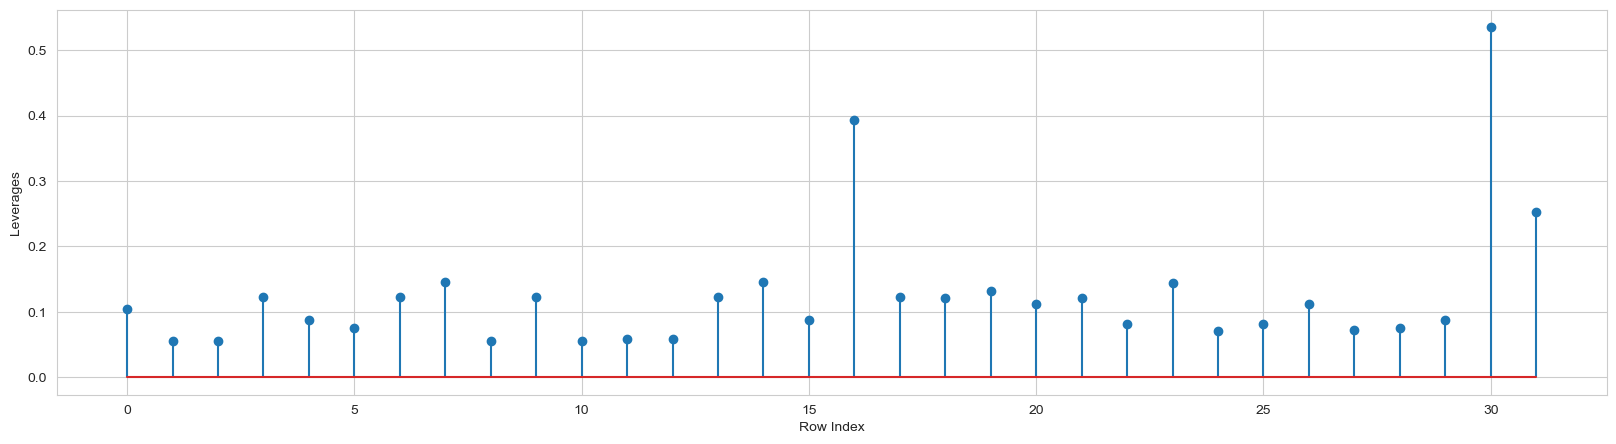

In [261]:
# Plot the leverages using the stem plot
fig=plt.figure(figsize=(20,5))
plt.stem(np.arange(df_metabol.shape[0]),np.round(leverage,3))
plt.xlabel('Row Index')
plt.ylabel('Leverages')
plt.show()

In [220]:
p = 4 # number of coefficients
n = df_metabol.shape[0]
2*(p)/n

0.25

According to that rule, case 31 has a high potential for influence.

In [237]:
res31 = results_metabol2.resid[filter_].values[0]
print("res31 = ", res31)

sigmahat =  np.sqrt((results_metabol2.resid**2).sum()/(n-p))
print('sigmahat', sigmahat)

standard_deviation_res31 = sigmahat*np.sqrt((1-leverage31))
print('standard_deviation_res31 = ', standard_deviation_res31)

studentized_residual31 = res31/standard_deviation_res31
print('studentized_residual31', studentized_residual31)

res31 =  -1.5023652936425513
sigmahat 1.207309252238255
standard_deviation_res31 =  0.8228506487176888
studentized_residual31 -1.8258055650606855


-1.8258 is moderately far from zero, but not alarmingly so.

This also can be extracted directed from the model output (influence).

In [239]:
student_resid = influence.resid_studentized_internal
print('studentized_residual31 = ', student_resid[filter_][0])

studentized_residual31 =  -1.8258055650606855


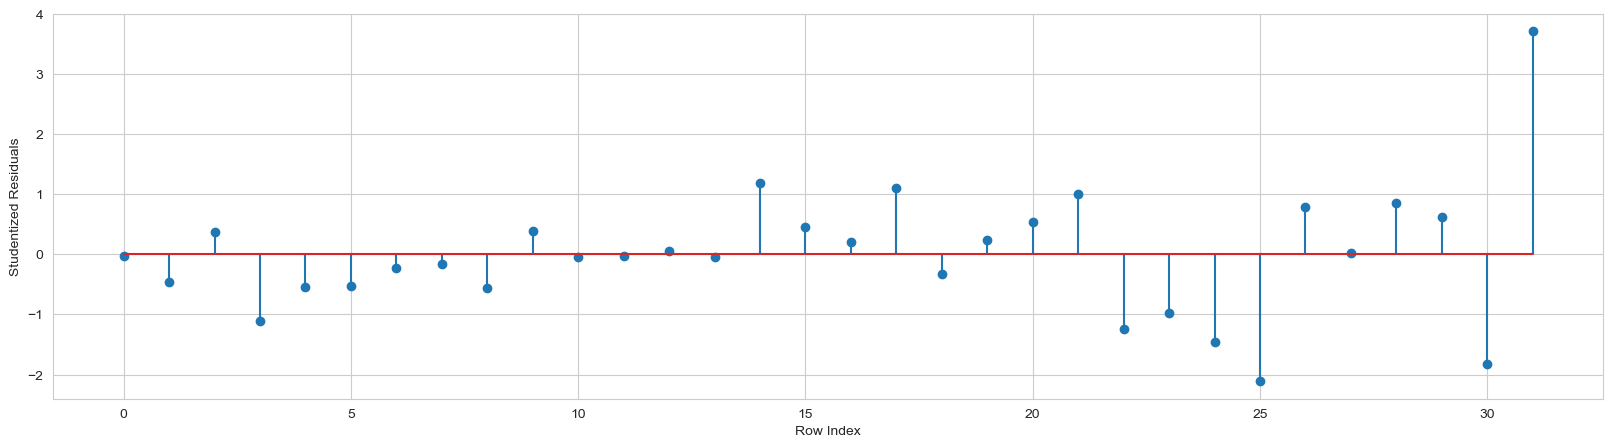

In [260]:
# Plot the studentized residuals using the stem plot
fig=plt.figure(figsize=(20,5))
plt.stem(np.arange(df_metabol.shape[0]),np.round(student_resid,3))
plt.xlabel('Row Index')
plt.ylabel('Studentized Residuals')
plt.show()

## Cook’s Distances for Flagging Influential Cases

Cook’s Distance is a case statistic that measures ***overall*** influence-the effect that omitting a case has on the estimated regression coefficients.

Cook's distance for a case $i$, (denoted as $D_i$) is defined as

$$D_i = \sum_{j=1}^n\frac{(\hat{Y}_{j(i)}-\hat{Y}_j)^2}{p\hat{\sigma}^2}$$

where 
$\hat{Y}_{j(i)}$ is the $j$th fitted value in a fit that excludes case $i$ from the data set and 

$\hat{Y}_j$ is the $j$th fitted value in a fit using all observations. 

$p$ is the number of coefficients and 

$\hat{\sigma}$ is the estimated variance from the fit, based on all observations.


The numerator measures how much the fitted values change when the $i$th case is deleted. 

The denominator scales this difference in a useful way.

***A case that is influential will have a large value of Cook’s Distance (close to or larger than 1).***

An equivalent expression for Cook’s Distance 

$$D_i = \frac{1}{p}(studres_i)^2\big(\frac{h_i}{1-h_i}\big)$$

This expression is useful for computing, since it does not require that the $i$th case actually be deleted.

Also, this shows that a large Cook’s Distance because it has a large studentized residual, a large leverage, or both.

In [248]:
D31 = (1/p)*(studentized_residual31)**2*(leverage31)/(1-leverage31)
print("D31 = ", D31)

D31 =  0.9606979400700386


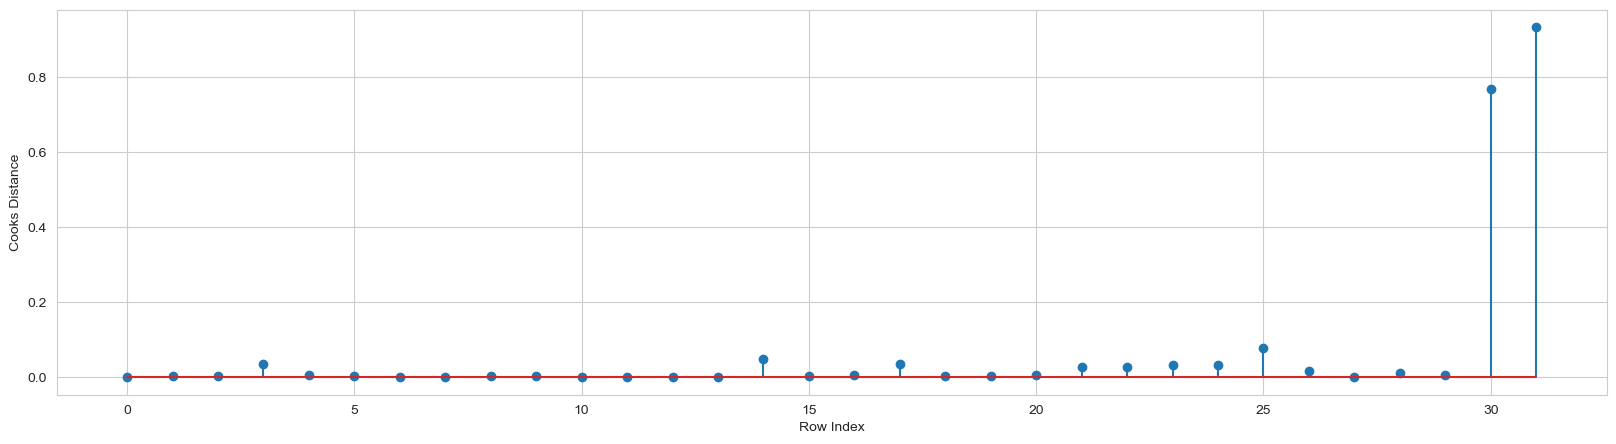

In [255]:
#Cook's D values (and p-values) as tuple of arrays
(cooks_d, p) = influence.cooks_distance

# Plot the influencers using the stem plot
fig=plt.figure(figsize=(20,5))
plt.stem(np.arange(df_metabol.shape[0]),np.round(cooks_d,3))
plt.xlabel('Row Index')
plt.ylabel('Cooks Distance')
plt.show()

In the top plot, the values of Cook’s Distance for cases 31 and 32 are obviously substantially larger than the rest, indicating that these two observations are influential.

Usually the trio of case influence measures— $D_i$ , $h_i$ , and $studres_i$ are examined jointly. 

In [256]:
from statsmodels.graphics.regressionplots import influence_plot

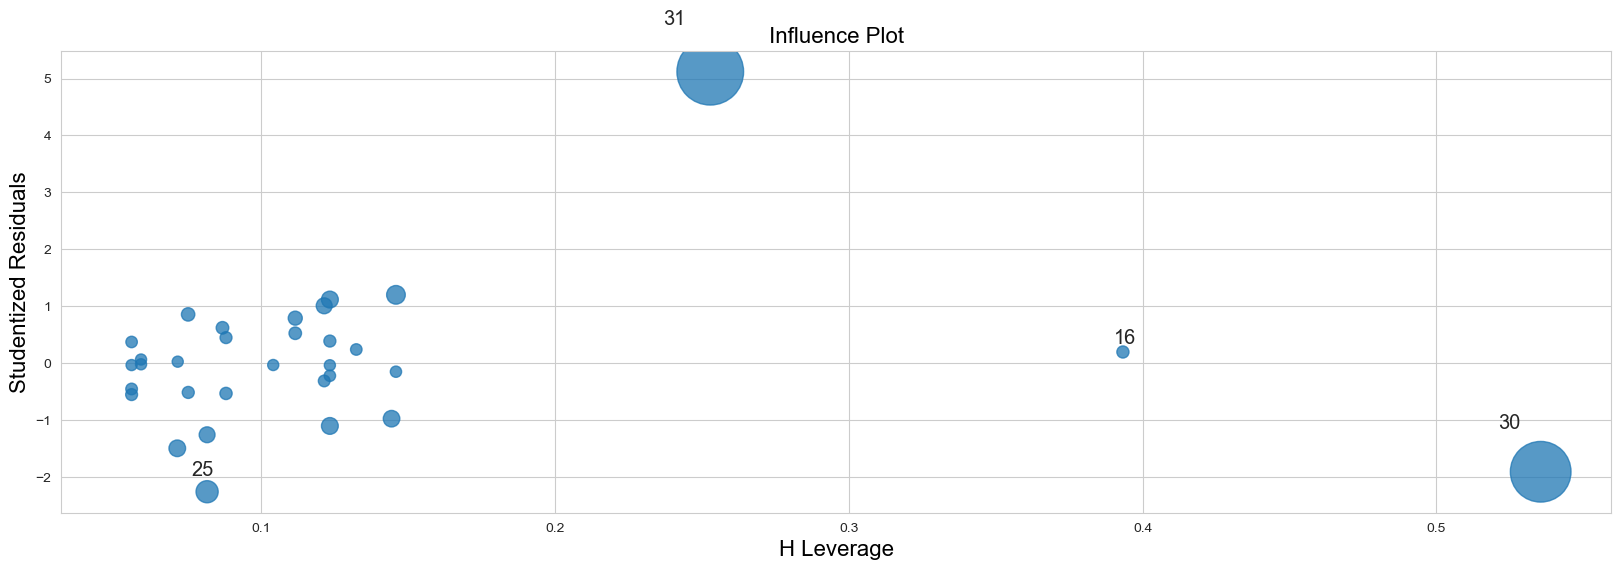

In [259]:
#size of the points represents the Cook's distance value
fig,ax=plt.subplots(figsize=(20,6))
fig=influence_plot(results_metabol2,ax = ax)
plt.show()

Let's set cases 31 and 32 aside and refit the model and examine the new residual plot.

Alcoholism is not of primary concern, and since so few alcoholics are included in the data set, it would be helpful if this variable could be ignored.

Can we drop all the terms involving alcoholism? We can test this with an extra of squares F-test discussed in the last chapter.

In [277]:
model_metabol_new = smf.ols('''Metabol ~ Gastric+C(Sex, Treatment(reference='Male'))+C(Alcohol,Treatment(reference='Non-alcoholic'))
+Gastric*C(Sex, Treatment('Male'))+C(Sex, Treatment('Male'))*C(Alcohol,Treatment(reference='Non-alcoholic'))
+Gastric*C(Alcohol,Treatment(reference='Non-alcoholic'))+Gastric*C(Sex, Treatment('Male'))*C(Alcohol,Treatment(reference='Non-alcoholic'))'''
                 , data = df_metabol.loc[0:29, :])
results_metabol_new = model_metabol_new.fit()
display(results_metabol.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Metabol   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     16.47
Date:                Tue, 04 Apr 2023   Prob (F-statistic):           9.35e-08
Time:                        21:25:16   Log-Likelihood:                -48.052
No. Observations:                  32   AIC:                             112.1
Df Residuals:                      24   BIC:                             123.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================================================================
                                                                                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                    -1.6597      1.000     -1.660      0.110      -3.723       0.404
C(Sex, Treatment(reference='Male'))[T.Female]                                                                 0.7329      0.666      1.100      0.282      -0.642       2.108
C(Alcohol, Treatment(reference='Non-alcoholic'))[T.Alcoholic]                                                 2.5521      1.946      1.311      0.202      -1.464       6.568
C(Sex, Treatment('Male'))[T.Female]                                                                           0.7329      0.666      1.100      0.282      -0.642       2.108
C(Sex, Treatment('Male'))[T.Female]:C(Alcohol, Treatment(reference='Non-alcoholic'))[T.Alcoholic]            -2.2517      4.394     -0.512      0.613     -11.320       6.816
Gastric                                                                                                       2.5142      0.343      7.322      0.000       1.805       3.223
Gastric:C(Sex, Treatment('Male'))[T.Female]                                                                  -1.6734      0.620     -2.698      0.013      -2.953      -0.393
Gastric:C(Alcohol, Treatment(reference='Non-alcoholic'))[T.Alcoholic]                                        -1.4587      1.053     -1.386      0.179      -3.632       0.714
Gastric:C(Sex, Treatment('Male'))[T.Female]:C(Alcohol, Treatment(reference='Non-alcoholic'))[T.Alcoholic]     1.1987      2.998      0.400      0.693      -4.989       7.386
==============================================================================
Omnibus:                        9.228   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               10.936
Skew:                           0.672   Prob(JB):                      0.00422
Kurtosis:                       5.529   Cond. No.                     6.11e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.74e-34. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [288]:
model_metabol_new2 = smf.ols('''Metabol ~ Gastric+C(Sex, Treatment(reference='Male'))+Gastric:C(Sex, Treatment('Male'))'''
                 , data = df_metabol.loc[0:29, :])
results_metabol_new2 = model_metabol_new2.fit()
display(results_metabol_new2.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Metabol   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     17.83
Date:                Tue, 04 Apr 2023   Prob (F-statistic):           1.71e-06
Time:                        22:23:01   Log-Likelihood:                -36.653
No. Observations:                  30   AIC:                             81.31
Df Residuals:                      26   BIC:                             86.91
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                         0.0695      0.802      0.087      0.932      -1.579       1.718
C(Sex, Treatment(reference='Male'))[T.Female]    -0.2668      0.993     -0.269      0.790      -2.308       1.775
Gastric                                           1.5654      0.407      3.843      0.001       0.728       2.403
Gastric:C(Sex, Treatment('Male'))[T.Female]      -0.7285      0.539     -1.351      0.188      -1.837       0.380
==============================================================================
Omnibus:                        0.150   Durbin-Watson:                   1.182
Prob(Omnibus):                  0.928   Jarque-Bera (JB):                0.367
Skew:                           0.021   Prob(JB):                        0.832
Kurtosis:                       2.460   Cond. No.                         19.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [265]:
from statsmodels.stats.anova import anova_lm

In [289]:
# Perform analysis of variance on fitted linear model (reduced model is in the first argument)
anova_results = anova_lm(results_metabol_new2, results_metabol_new)
print('\nANOVA results full model')
print(anova_results)


ANOVA results full model
   df_resid        ssr  df_diff  ss_diff         F  Pr(>F)
0      26.0  20.223602      0.0      NaN       NaN     NaN
1      22.0  19.483453      4.0  0.74015  0.208937  0.9307


The F -statistic is 0.21.

p-value is 0.93.

So the data are consistent with there being no alcoholism effect.

The resulting model is 

$$\mu\{metabolism|gast,fem\} = \beta_0+\beta_1 gast + \beta_2 fem+\beta_3 (gast*fem)$$

$\beta_2$ is insignificant according to the model result and the scatter plot confirms it (both men and women intercepts are near zero). Also it makes sense since there is no first-pass metabolism if there is no activity of the enzyme.   

Even though $\beta_3$ is insignificant, the scatter plot suggests an interaction between sex and gastric level.

Hence we drop only $\beta_2$ and the updates model is

$$\mu\{metabolism|gast,fem\} = \beta_0+\beta_1 gast + \beta_2 (gast*fem)$$

In [294]:
model_metabol_new3 = smf.ols('''Metabol ~ Gastric+Gastric:C(Sex, Treatment('Male'))'''
                 , data = df_metabol.loc[0:29, :])
results_metabol_new3 = model_metabol_new3.fit()
display(results_metabol_new3.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Metabol   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     27.66
Date:                Tue, 04 Apr 2023   Prob (F-statistic):           2.91e-07
Time:                        22:24:02   Log-Likelihood:                -36.695
No. Observations:                  30   AIC:                             79.39
Df Residuals:                      27   BIC:                             83.59
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                      -0.1044      0.465     -0.225      0.824      -1.058       0.850
Gastric                                         1.6492      0.258      6.404      0.000       1.121       2.178
Gastric:C(Sex, Treatment('Male'))[T.Female]    -0.8646      0.181     -4.774      0.000      -1.236      -0.493
==============================================================================
Omnibus:                        0.316   Durbin-Watson:                   1.164
Prob(Omnibus):                  0.854   Jarque-Bera (JB):                0.488
Skew:                           0.003   Prob(JB):                        0.783
Kurtosis:                       2.375   Cond. No.                         7.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can confirm this model with an another extra sum of squares F-test.

In [295]:
# Perform analysis of variance on fitted linear model (reduced model is in the first argument)
anova_results = anova_lm(results_metabol_new3, results_metabol_new2)
print('\nANOVA results full model')
print(anova_results)


ANOVA results full model
   df_resid        ssr  df_diff  ss_diff        F    Pr(>F)
0      27.0  20.279723      0.0      NaN      NaN       NaN
1      26.0  20.223602      1.0  0.05612  0.07215  0.790352


p-value is 0.79, the smaller model is adequate.

Note that the updated range of the level of gastric AD activity is from 0.8 to 3.0. 

The estimated mean first-pass metabolism for males divided by the mean first-pass metabolism for females is $\frac{\hat{\beta_1}}{\hat{\beta}_1+\hat{\beta}_2} = 2.1$.

